In [11]:
import kagglehub

path = kagglehub.dataset_download("ananthu017/emotion-detection-fer")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1


In [58]:
import numpy as np
import pandas as pd
import os
import itertools
import plotly.express as px
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from sklearn.model_selection import train_test_split


In [13]:
traindf='/root/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1/train'
image_paths = []
labels = []

folds = os.listdir(traindf)
for fold in folds:
    foldpath = os.path.join(traindf, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        image_paths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(image_paths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_data = pd.concat([Fseries, Lseries], axis= 1)

In [14]:
test='/root/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1/test'
image_paths = []
labels = []
folds = os.listdir(test)
for fold in folds:
    foldpath = os.path.join(test, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        image_paths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(image_paths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_data = pd.concat([Fseries, Lseries], axis= 1)

In [39]:
valid_df, test_df = train_test_split(test_data,  train_size= 0.6, shuffle= True, random_state= 123)

In [24]:
img_size = 48
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [42]:
train_generator = train_datagen.flow_from_directory(directory = traindf,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )
test_generator = test_datagen.flow_from_directory(directory = test,
                                                  target_size = (img_size,img_size),
                                                  batch_size = 64,
                                                  color_mode = "grayscale",
                                                  class_mode = "categorical"
                                                  )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [53]:
data = {
    "labels": ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"],
    "counts": [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)]
}
df = pd.DataFrame(data)
fig = px.bar(df,  # Pass the DataFrame here
             x="labels",
             y="counts",
            color = np.unique(train_generator.classes) ,
             color_continuous_scale="Blues")

fig.update_xaxes(title="Emotions")
fig.update_yaxes(title="Number of Images")
fig.update_layout(showlegend=True,
    title={
        'text': 'Train Data Distribution ',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [56]:
fig_pie = px.pie(df, values='counts', names='labels', title='Train Data Distribution',
                 color_discrete_sequence=px.colors.sequential.Blues)
fig_pie.show()


In [17]:
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

In [18]:
epochs = 60
batch_size = 64

In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,496,903 (17.15 MB)

 Trainable params: 4,492,935 (17.14 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [20]:
history = model.fit(x = train_generator,epochs = epochs,validation_data = validation_generator) #done it for 3 times to increase accuracy

Epoch 1/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 46s 84ms/step - accuracy: 0.1825 - loss: 9.5989 - val_accuracy: 0.1341 - val_loss: 8.9036
Epoch 2/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.2289 - loss: 8.4920 - val_accuracy: 0.2849 - val_loss: 7.5757
Epoch 3/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.2438 - loss: 7.5042 - val_accuracy: 0.2912 - val_loss: 6.5554
Epoch 4/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 24s 66ms/step - accuracy: 0.2703 - loss: 6.4923 - val_accuracy: 0.3254 - val_loss: 5.6207
Epoch 5/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.3003 - loss: 5.5680 - val_accuracy: 0.3568 - val_loss: 4.8639
Epoch 6/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.3298 - loss: 4.7601 - val_accuracy: 0.4099 - val_loss: 4.0657
Epoch 7/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.3582 - loss: 4.0840 - val_accuracy: 0.4316 - val_loss: 3.5155
Epoch 8/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.3832 - loss: 3.5357 - 

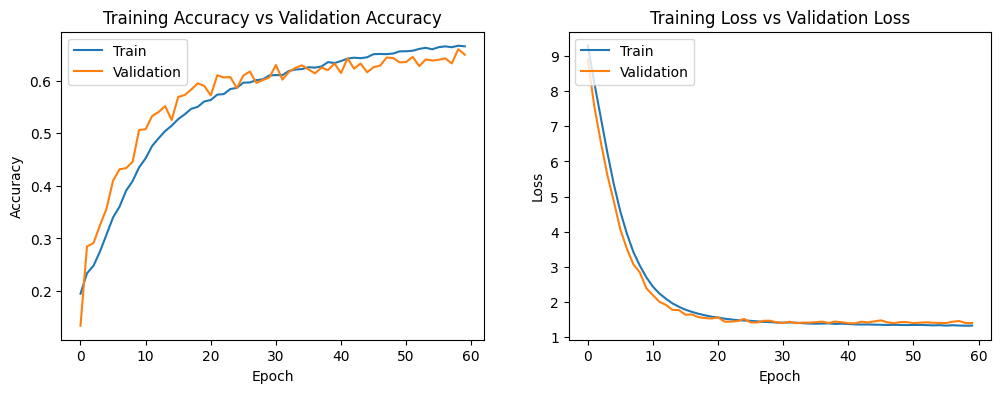

In [22]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [27]:
#prediction
pred=model.predict(test_generator)
ypred=np.argmax(pred,axis=1)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step


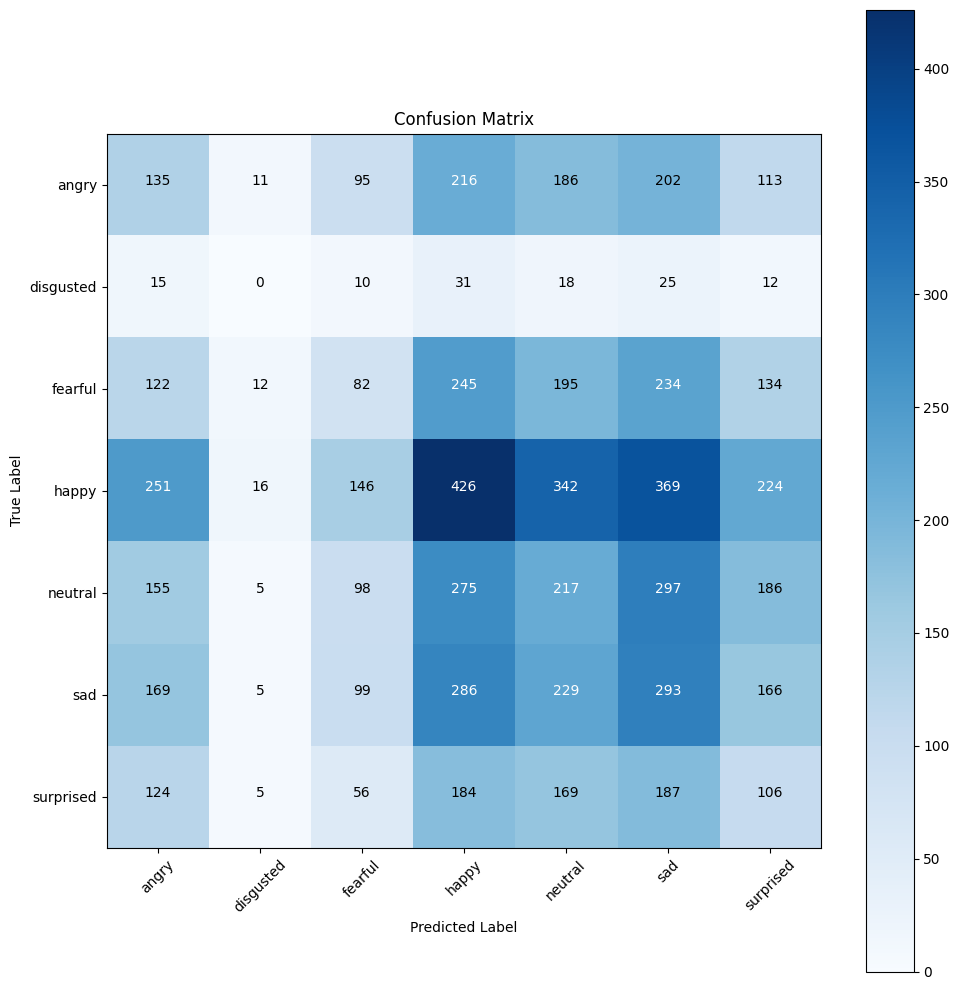

In [35]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_generator.classes, ypred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [63]:
def predict_image(image_path, model):
    img = image.load_img(image_path, color_mode="grayscale", target_size=(48, 48))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255

    custom = model.predict(x)
    emotion_labels = ['Angry', 'Disgusted', 'FearFul', 'Happy', 'Neutral', 'sad', 'Surprised']
    predicted_class = np.argmax(custom)
    return emotion_labels[predicted_class]


image_path = "/content/im0 (1).png"
predicted_emotion = predict_image(image_path, model)
print(f"Predicted Emotion: {predicted_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Emotion: Happy
